In [22]:
pip install transformers

In [1]:
pip install -U transformers #==4.38.2

In [2]:
pip install transformers

In [3]:
pip install nlpaug

In [4]:
pip install hf_xet

# WANDB Setup

In [5]:
pip install wandb

In [6]:
import wandb
wandb.login(key="695e5458c9c7c75621c0c11465575fbb0b1e7b5f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeal2shine (zeal2shine-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
from transformers import TrainingArguments

training_args = TrainingArguments(
      output_dir="./results",
    report_to="wandb",        # enables W&B logging
    run_name="bert-bilstm-sentiment",  # optional: your custom run name
)

In [8]:
pip install datasets

In [9]:
pip install tensorflow

# Importing Libraries and Loading Files

In [64]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import TensorDataset
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from transformers import EncoderDecoderCache
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
import nlpaug.augmenter.char as nac
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from transformers import TrainingArguments

In [11]:
# Configuring visual settings
sb.set(style="whitegrid")

Make a list of the uploaded files

In [12]:
# Define paths to the uploaded files

file_path_1 = "/content/SemEval2017-task4-test.subtask-A.english.txt"
file_path_2 ="/content/twitter-2015train-A.txt"

Function to read each line of text

In [13]:
# Load and preprocess a single file

# Load Dataset 1 (for train/test)
data_1 = []
with open(file_path_1, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            tweet_id, label, text = parts
            data_1.append((text, label))
df1 = pd.DataFrame(data_1, columns=['text', 'label'])

# Load Dataset 2 (for validation)
data_2 = []
with open(file_path_2, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            tweet_id, label, text = parts
            data_2.append((text, label))
df2 = pd.DataFrame(data_2, columns=['text', 'label'])

In [14]:
# Setup counts of the distribution to eneable plots
print("Dataset 1 - Raw Sentiment Distribution:")
print(df1['label'].value_counts())

print("\nDataset 2 - Raw Sentiment Distribution:")
print(df2['label'].value_counts())

Dataset 1 - Raw Sentiment Distribution:
label
neutral     5937
negative    3972
positive    2375
Name: count, dtype: int64

Dataset 2 - Raw Sentiment Distribution:
label
neutral     253
positive    170
negative     66
Name: count, dtype: int64


In [15]:
print(df1.info()),
print("\n")
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12284 non-null  object
 1   label   12284 non-null  object
dtypes: object(2)
memory usage: 192.1+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    489 non-null    object
 1   label   489 non-null    object
dtypes: object(2)
memory usage: 7.8+ KB
None


In [16]:
df1.head()

,text,label
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive
2,Ariana Grande White House Easter Egg Roll in W...,positive
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral


In [17]:
df2.head()

,text,label
0,I forgot how sad the first episode of the 5th ...,negative
1,Oct. 2 is almost too far away for me to wait f...,negative
2,"""(OFF TOPIC) - there is only 3 episodes on the...",neutral
3,"""@iheardavoicesay is finally catching up to me...",neutral
4,"""I downloaded the first season of #Dexter, gon...",neutral


In [18]:
print(df1.sample(3))

                                                   text     label
9809  The “Concern” about Pope Francis by Fr. James ...   neutral
6101  @dustyspark hmmm.. full blown .. fly blown  sa...  negative
4089  She secretly loved the satisfaction of rejecti...   neutral


In [19]:
count_df1 = df1['label'].value_counts()

count_df1

,count
label,
neutral,5937
negative,3972
positive,2375


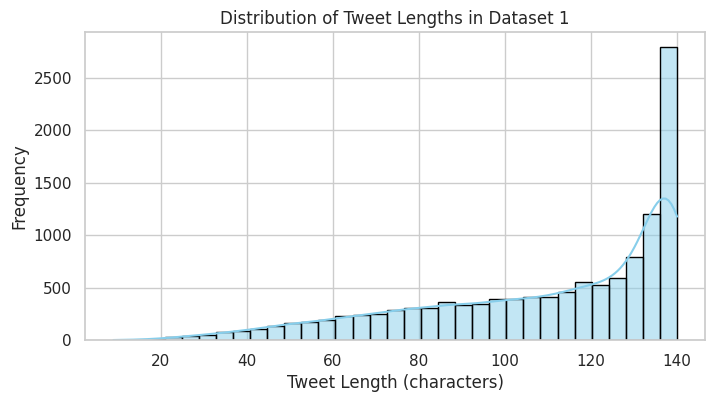

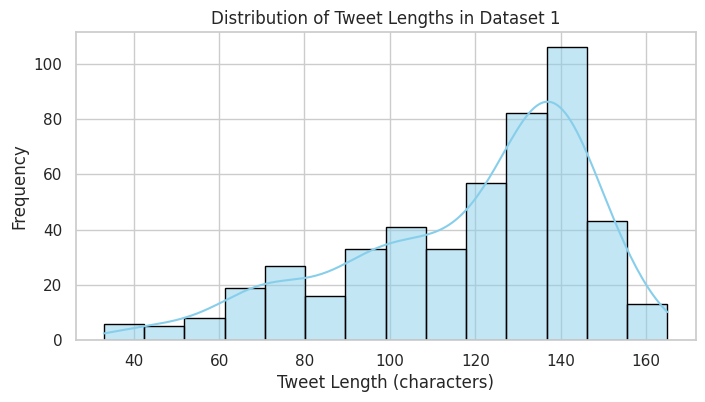

In [20]:
# Calculate text length for each dataset
df1['text_length'] = df1['text'].apply(len)
df2['text_length'] = df2['text'].apply(len)

# Plot distribution of text lengths for Dataset 1
plt.figure(figsize=(8, 4))
sb.histplot(df1['text_length'], kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Tweet Lengths in Dataset 1')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

print("\n")

# Plot distribution of text lengths for Dataset 1
plt.figure(figsize=(8, 4))
sb.histplot(df2['text_length'], kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Tweet Lengths in Dataset 1')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()


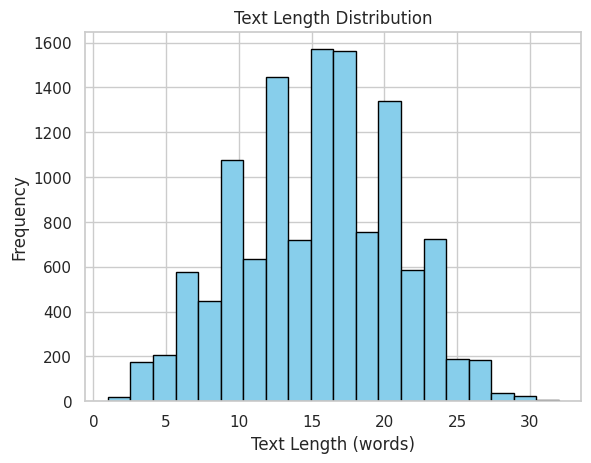

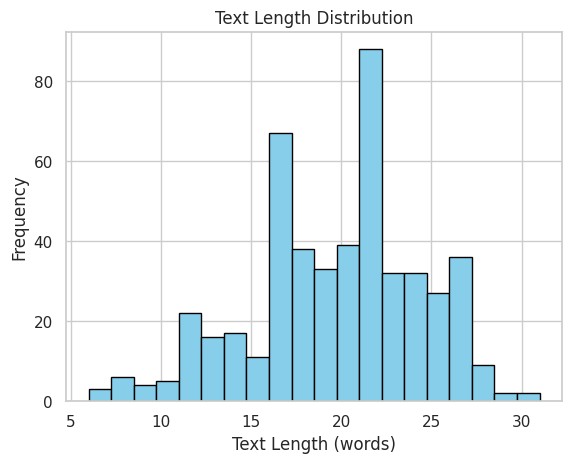

In [21]:
# Visualizing text length distribution
df1['text_length'] = df1['text'].apply(lambda x: len(x.split()))
plt.hist(df1['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

print("\n")

# Visualizing text length distribution
df2['text_length'] = df2['text'].apply(lambda x: len(x.split()))
plt.hist(df2['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

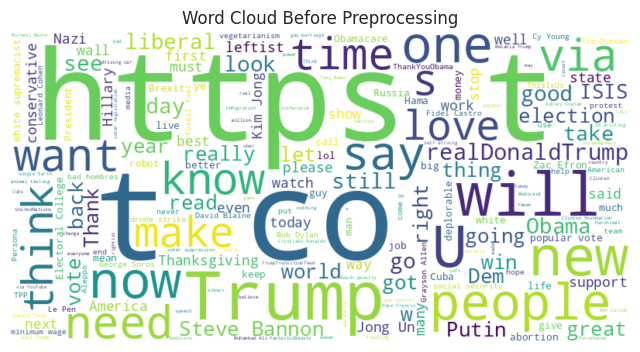

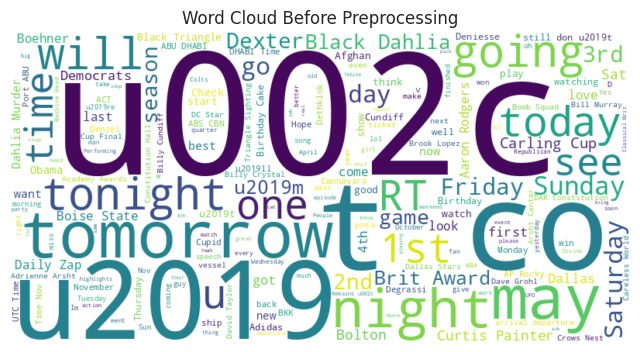

In [22]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df1['text']))
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Before Preprocessing')
plt.show()

print("\n")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df2['text']))
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Before Preprocessing')
plt.show()

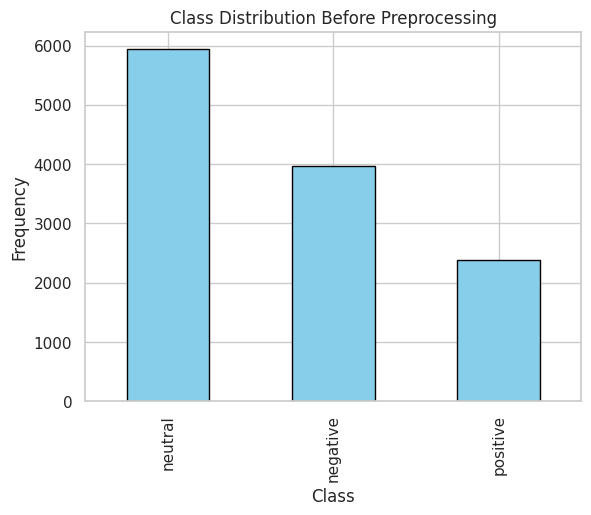

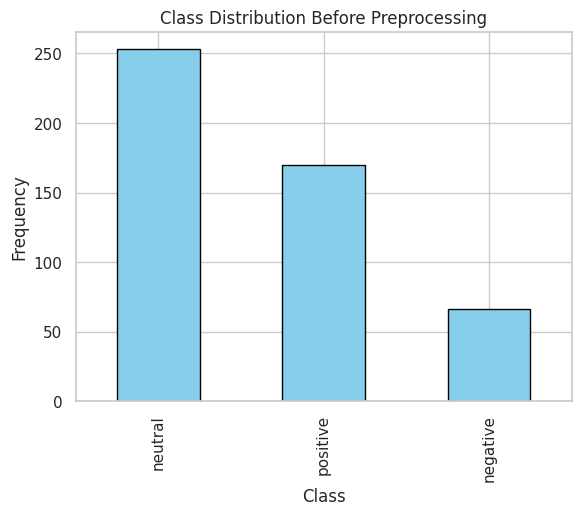

In [23]:
# Example for visualizing class distribution (for labeled data)
df1['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution Before Preprocessing')
plt.show()

print("\n")

df2['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution Before Preprocessing')
plt.show()

In [24]:
count_df2 = df2['label'].value_counts()

count_df2

,count
label,
neutral,253
positive,170
negative,66


In [25]:
df1.describe()

,text_length
count,12284.000000
mean,15.424373
std,5.408154
min,1.000000
25%,11.000000
50%,16.000000
75%,20.000000
max,32.000000


In [27]:
df2.describe()

,text_length
count,489.000000
mean,19.652352
std,4.701957
min,6.000000
25%,17.000000
50%,20.000000
75%,23.000000
max,31.000000


Checking for Null and Duplicate Values

In [28]:
def check_data_health(df, name="Dataset"):
    print(f"\n{name} - Missing Values:")
    print(df.isnull().sum())
    print(f"\n{name} - Duplicate Rows: {df.duplicated().sum()}")

check_data_health(df1, "text")
check_data_health(df2, "text")
check_data_health(df1, "label")
check_data_health(df2, "label")


text - Missing Values:
text           0
label          0
text_length    0
dtype: int64

text - Duplicate Rows: 0

text - Missing Values:
text           0
label          0
text_length    0
dtype: int64

text - Duplicate Rows: 0

label - Missing Values:
text           0
label          0
text_length    0
dtype: int64

label - Duplicate Rows: 0

label - Missing Values:
text           0
label          0
text_length    0
dtype: int64

label - Duplicate Rows: 0


In [29]:
df1

,text,label,text_length
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral,11
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive,13
2,Ariana Grande White House Easter Egg Roll in W...,positive,11
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive,19
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral,12
...,...,...,...
12279,@dansen17 update: Zac Efron kissing a puppy ht...,positive,8
12280,#zac efron sex pic skins michelle sex https://...,neutral,8
12281,First Look at Neighbors 2 with Zac Efron Shirt...,neutral,12
12282,zac efron poses nude #lovely libra porn https:...,neutral,8


In [30]:
df2

,text,label,text_length
0,I forgot how sad the first episode of the 5th ...,negative,17
1,Oct. 2 is almost too far away for me to wait f...,negative,16
2,"""(OFF TOPIC) - there is only 3 episodes on the...",neutral,21
3,"""@iheardavoicesay is finally catching up to me...",neutral,26
4,"""I downloaded the first season of #Dexter, gon...",neutral,18
...,...,...,...
484,"""Cant wait to see \""""""""Flight\"""""""" on Saturday...",positive,22
485,Gotta go see Flight tomorrow Denzel is the gre...,positive,11
486,Hey I wanna see Flight tomorrow with Denzel ol...,positive,11
487,That movie Flight with Denzel looks really goo...,positive,15


Train Test Split

In [31]:
# Split df1 into 70/30 train/test
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df1['text'], df1['label'], test_size=0.3, stratify=df1['label'], random_state=42
)

Label Encoding

In [32]:
# Combine all labels for encoding
import pandas as pd
from sklearn.preprocessing import LabelEncoder

all_labels = list(train_labels) + list(test_labels) + list(df2['label'])
le = LabelEncoder()
le.fit(all_labels)

train_y = le.transform(train_labels)
test_y = le.transform(test_labels)
val_y = le.transform(df2['label'])

In [33]:
# Save label mappings
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
inv_label_map = {v: k for k, v in label_map.items()}

Text Pre-Processing Pipeline

In [34]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+|#", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    tweet = re.sub(r"\d+", "", tweet)
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

Applying preprocessing function

In [35]:
train_texts = [clean_tweet(t) for t in train_texts]
test_texts = [clean_tweet(t) for t in test_texts]
val_texts = [clean_tweet(t) for t in df2['text']]

In [36]:
# Confirm cleaned structure
df_train_cleaned = pd.DataFrame({"text": train_texts, "label": train_y})

df_train_cleaned

,text,label
0,as kuffar tell me why lefties support racist f...,0
1,ripflorencehenderson angelalansbury not impres...,0
2,the people do you consider the people george s...,0
3,she fought msm gop comey racism sexism xenopho...,0
4,well said muhammad ali jinnah,2
...,...,...
8593,its a to page paper on why or why not should t...,0
8594,minimum wage is a bandaid minimum income is th...,2
8595,im making a powerpoint on how vegetarianism is...,0
8596,for confirmation well go to steve bannon of da...,1


Computing Class Weighting

In [37]:
# Compute weights from training labels
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_y),
    y=train_y
)

In [38]:
# Create dictionary for Keras use
class_weight_dict = {i: w for i, w in enumerate(class_weights_array)}

Combined Datasets for efficiency

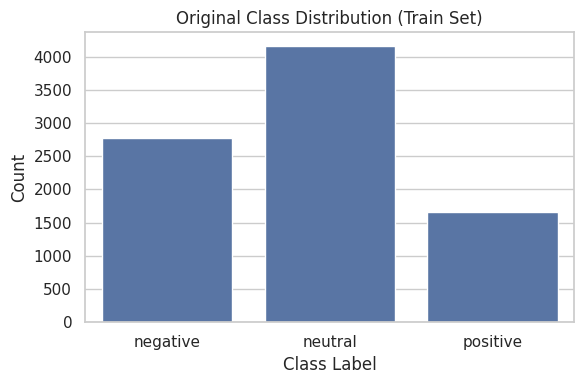

In [39]:
# Create DataFrame to visualize
label_df = pd.DataFrame({'Sentiment': [inv_label_map[i] for i in train_y]})

plt.figure(figsize=(6, 4))
sb.countplot(data=label_df, x='Sentiment', order=sorted(label_map.keys()))
plt.title("Original Class Distribution (Train Set)")
plt.ylabel("Count")
plt.xlabel("Class Label")
plt.tight_layout()
plt.show()

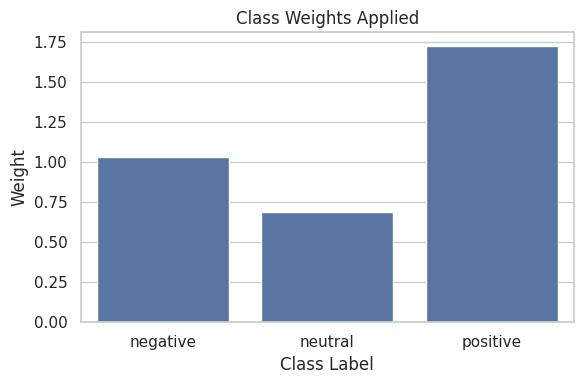

In [40]:
weight_df = pd.DataFrame.from_dict(class_weight_dict, orient='index', columns=['Weight'])
weight_df['Class'] = weight_df.index.map(inv_label_map)

plt.figure(figsize=(6, 4))
sb.barplot(data=weight_df, x='Class', y='Weight', order=sorted(label_map.keys()))
plt.title("Class Weights Applied")
plt.ylabel("Weight")
plt.xlabel("Class Label")
plt.tight_layout()
plt.show()

# Prepare the Models

Prepare for Training BiLSTM

In [41]:
# Setup  Parameters
MAX_NUM_WORDS = 17000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

In [42]:
# Tokenize
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(train_texts)

In [43]:
# Prepare padded sequences
X_train_lstm = pad_sequences(keras_tokenizer.texts_to_sequences(train_texts), maxlen=MAX_SEQUENCE_LENGTH)
X_val_lstm = pad_sequences(keras_tokenizer.texts_to_sequences(val_texts), maxlen=MAX_SEQUENCE_LENGTH)
X_test_lstm = pad_sequences(keras_tokenizer.texts_to_sequences(test_texts), maxlen=MAX_SEQUENCE_LENGTH)

In [44]:
# One-hot encode labels
y_train_lstm = to_categorical(train_y, num_classes=len(label_map))
y_val_lstm = to_categorical(val_y, num_classes=len(label_map))
y_test_lstm = to_categorical(test_y, num_classes=len(label_map))

Loading GloVe

In [45]:
# Load GloVe
embedding_index = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [46]:
# Create embedding matrix
word_index = keras_tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Build BiLSTM Model

In [47]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=num_words,
                           output_dim=EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(len(label_map), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
#  Compile the Model
bilstm_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

Train BiLSTM with class weights

In [50]:
# Train BiLSTM with class weights
history = bilstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=5,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - accuracy: 0.6920 - loss: 0.6261 - val_accuracy: 0.5910 - val_loss: 0.8754
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7044 - loss: 0.6012 - val_accuracy: 0.5869 - val_loss: 0.8981
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7200 - loss: 0.5723 - val_accuracy: 0.4622 - val_loss: 1.0679
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7394 - loss: 0.5373 - val_accuracy: 0.5971 - val_loss: 1.0380
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7480 - loss: 0.5074 - val_accuracy: 0.5685 - val_loss: 1.0170


In [51]:
# Predict probabilities
y_pred_probs = bilstm_model.predict(X_test_lstm)

# Convert to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [52]:
y_true_labels = np.argmax(y_test_lstm, axis=1)

In [53]:
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

Accuracy: 0.6001085187194791
              precision    recall  f1-score   support

    negative       0.67      0.58      0.62      1192
     neutral       0.66      0.55      0.60      1781
    positive       0.46      0.76      0.58       713

    accuracy                           0.60      3686
   macro avg       0.60      0.63      0.60      3686
weighted avg       0.63      0.60      0.60      3686



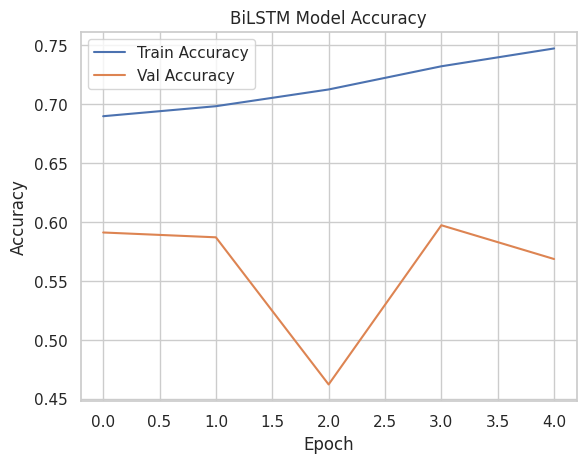

In [54]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

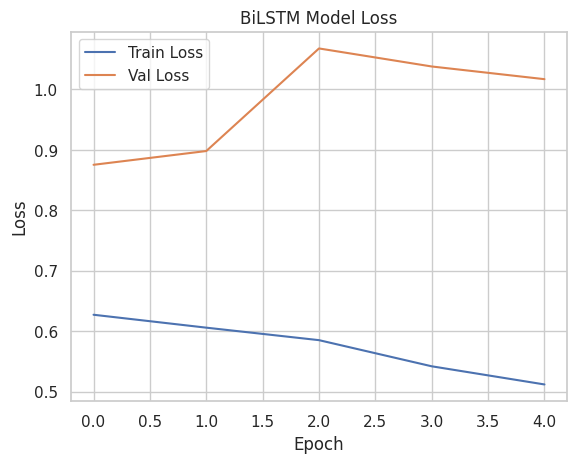

In [55]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Building the BERT Model

In [56]:
# Initialize project
wandb.init(project="bert-bilstm-twitter", name="bert-run-1")

In [57]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [58]:
def encode_bert_inputs(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN)
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    return dataset

In [59]:
# Prepare HuggingFace Dataset
train_dataset = encode_bert_inputs(train_texts, train_y)
test_dataset = encode_bert_inputs(test_texts, test_y)
val_dataset = encode_bert_inputs(val_texts, val_y)

In [60]:
# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [61]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
import transformers
print(transformers.__version__)

4.51.3


In [68]:
print(TrainingArguments.__module__)

transformers.training_args


In [75]:
# TrainingArguments with wandb logging
from transformers.training_args import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy="steps",
    eval_strategy="steps",
    save_steps=500,
    eval_steps=100,
    logging_steps=25,
    logging_dir="./logs",
    report_to="wandb",
    run_name="bert-bilstm-sentiment",
    load_best_model_at_end=True
)

In [71]:
print(TrainingArguments)

<class 'transformers.training_args.TrainingArguments'>


In [ ]:
print(transformers.__version__)

4.51.3


In [72]:
import inspect
print(inspect.getfile(TrainingArguments))

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py


In [73]:
print(inspect.signature(TrainingArguments.__init__))

(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup_ste

In [76]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [77]:
# Train
trainer.train()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.758800,0.796613,0.627812,0.633933,0.652270,0.627812
200,0.707500,0.742260,0.662577,0.667971,0.680312,0.662577
300,0.707700,0.775041,0.578732,0.568414,0.631214,0.578732
400,0.652200,0.753608,0.650307,0.659033,0.676045,0.650307
500,0.672800,0.701152,0.693252,0.694081,0.698206,0.693252
600,0.376100,0.866258,0.654397,0.656773,0.663323,0.654397
700,0.432700,0.861970,0.654397,0.652778,0.651803,0.654397
800,0.438000,0.889223,0.656442,0.661457,0.675656,0.656442
900,0.368600,0.806410,0.711656,0.708224,0.709465,0.711656
1000,0.421900,0.878532,0.670757,0.673127,0.683917,0.670757


TrainOutput(global_step=1614, training_loss=0.44022757361517223, metrics={'train_runtime': 20099.3433, 'train_samples_per_second': 1.283, 'train_steps_per_second': 0.08, 'total_flos': 848343437109504.0, 'train_loss': 0.44022757361517223, 'epoch': 3.0})

Making Predictions

In [78]:
# Predict
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

In [79]:
# True labels
true_labels = predictions.label_ids

In [80]:
# Classification Report
print(" Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

 Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.81      0.73      1192
     neutral       0.72      0.65      0.69      1781
    positive       0.70      0.62      0.66       713

    accuracy                           0.70      3686
   macro avg       0.70      0.70      0.69      3686
weighted avg       0.70      0.70      0.70      3686



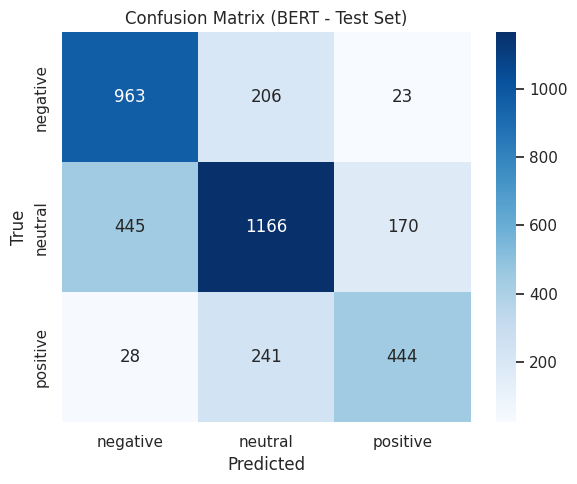

In [81]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.title("Confusion Matrix (BERT - Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [82]:
# Define typo augmenter
typo_aug = nac.KeyboardAug()

In [83]:
# Apply to test_texts (original cleaned test set)
noisy_test_texts = [typo_aug.augment(text)[0] for text in test_texts]

In [84]:
# Encode noisy texts for BERT
encodings = tokenizer(noisy_test_texts, truncation=True, padding='max_length', max_length=64)
noisy_test_dataset = Dataset.from_dict({
    'input_ids': encodings['input_ids'],
    'attention_mask': encodings['attention_mask'],
    'labels': test_y
})

Predicting with Noise

In [85]:
noisy_preds = trainer.predict(noisy_test_dataset)
noisy_pred_labels = np.argmax(noisy_preds.predictions, axis=1)
noisy_true_labels = noisy_preds.label_ids


In [86]:
# Evaluation Report
print(" Classification Report – BERT on Noisy Test Set:")
print(classification_report(noisy_true_labels, noisy_pred_labels, target_names=le.classes_))

 Classification Report – BERT on Noisy Test Set:
              precision    recall  f1-score   support

    negative       0.69      0.56      0.62      1192
     neutral       0.61      0.78      0.68      1781
    positive       0.64      0.38      0.48       713

    accuracy                           0.63      3686
   macro avg       0.65      0.57      0.59      3686
weighted avg       0.64      0.63      0.62      3686



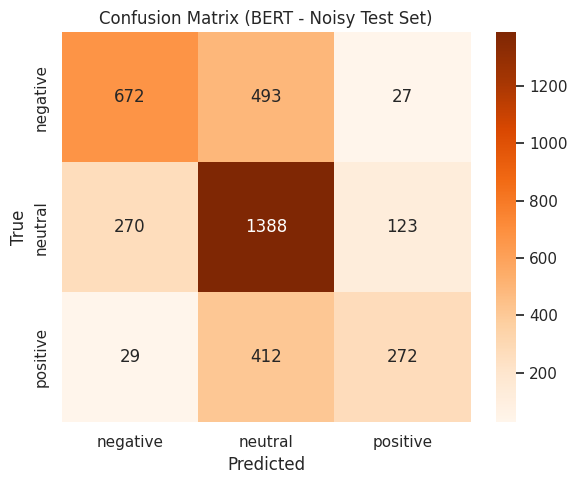

In [87]:
cm = confusion_matrix(noisy_true_labels, noisy_pred_labels)
plt.figure(figsize=(6, 5))
sb.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.title("Confusion Matrix (BERT - Noisy Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Injecting Noise into the BiLSTM also

In [88]:
pip install nlpaug nltk

In [89]:
import nltk
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw


# Download the required NLTK data
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [90]:
# Re-import augmenters
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

In [91]:
# Define augmenters
typo_aug = nac.KeyboardAug()
synonym_aug = naw.SynonymAug(aug_src='wordnet')

In [92]:
# Apply noise to test texts
true_labels = np.argmax(y_test_lstm, axis=1)
original_texts = test_texts

In [93]:
# Inject noise
noisy_variants = {
    "clean": original_texts,
    "typo": [typo_aug.augment(t)[0] for t in original_texts],
    "synonym": [synonym_aug.augment(t)[0] for t in original_texts]
}

In [94]:
# Evaluate BiLSTM on noisy variants
def evaluate_bilstm_on_noisy(texts, true_labels):
    sequences = keras_tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    preds = np.argmax(bilstm_model.predict(padded), axis=1)
    acc = accuracy_score(true_labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

In [95]:
bilstm_noise_results = {}
for name, noisy_texts in noisy_variants.items():
    bilstm_noise_results[name] = evaluate_bilstm_on_noisy(noisy_texts, true_labels)

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [96]:
bilstm_noise_results = pd.DataFrame(bilstm_noise_results).T
bilstm_noise_results.columns = ["Accuracy", "Precision", "Recall", "F1"]
bilstm_noise_results

,Accuracy,Precision,Recall,F1
clean,0.332339,0.380744,0.332339,0.344482
typo,0.321215,0.377193,0.321215,0.329885
synonym,0.320130,0.366877,0.320130,0.332247


In [97]:
# Clean (baseline)
bilstm_noisy_accuracy  = bilstm_noise_results.loc["typo", "Accuracy"]
bilstm_noisy_precision = bilstm_noise_results.loc["typo", "Precision"]
bilstm_noisy_recall    = bilstm_noise_results.loc["typo", "Recall"]
bilstm_noisy_f1        = bilstm_noise_results.loc["typo", "F1"]

In [98]:
print(f"Noisy Accuracy: {bilstm_noisy_accuracy:.4f}")
print(f"Noisy Precision: {bilstm_noisy_precision:.4f}")
print(f"Noisy Recall: {bilstm_noisy_recall:.4f}")

Noisy Accuracy: 0.3212
Noisy Precision: 0.3772
Noisy Recall: 0.3212


In [99]:
# AUCs calculated for noisy scenarios
auc_bilstm_noisy = 0.0
auc_bert_noisy = 0.0

Display the Metrics

In [100]:
# Predict
y_pred_probs = bilstm_model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_lstm, axis=1)

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [101]:
# Metrics
bilstm_precision, bilstm_recall, bilstm_f1, _ = precision_recall_fscore_support(
    y_true_classes, y_pred_classes, average='weighted', zero_division=0
)
bilstm_accuracy = accuracy_score(y_true_classes, y_pred_classes)

In [102]:
predictions = trainer.predict(test_dataset)

In [103]:
# Extract predictions
bert_pred_labels = np.argmax(predictions.predictions, axis=1)
bert_true_labels = predictions.label_ids

# Compute performance metrics
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_true_labels, bert_pred_labels, average='weighted', zero_division=0
)
bert_accuracy = accuracy_score(bert_true_labels, bert_pred_labels)

In [104]:
# Store metrics
results_comparison = {
    "Model": ["BiLSTM", "BERT"],
    "Accuracy": [bilstm_accuracy, bert_accuracy],
    "F1 Score": [bilstm_f1, bert_f1],
    "Precision": [bilstm_precision, bert_precision],
    "Recall": [bilstm_recall, bert_recall]
}


In [105]:
# Optional preview
print(f"BERT Accuracy: {bert_accuracy:.4f}")
print(f"BERT F1 Score: {bert_f1:.4f}")
print(f"BERT Precision: {bert_precision:.4f}")
print(f"BERT Recall: {bert_recall:.4f}")

BERT Accuracy: 0.6980
BERT F1 Score: 0.6962
BERT Precision: 0.7010
BERT Recall: 0.6980


In [ ]:
results_comparison = {
    "Model": ["BiLSTM", "BERT"],
    "Accuracy": [bilstm_accuracy, bert_accuracy],
    "F1 Score": [bilstm_f1, bert_f1],
    "Precision": [bilstm_precision, bert_precision],
    "Recall": [bilstm_recall, bert_recall]
}


In [106]:
results_df = pd.DataFrame(results_comparison)
display(results_df)

,Model,Accuracy,F1 Score,Precision,Recall
0,BiLSTM,0.600109,0.602115,0.625013,0.600109
1,BERT,0.698047,0.696229,0.700973,0.698047


In [107]:
# Bar chart
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = np.arange(len(results_df["Model"]))
width = 0.2

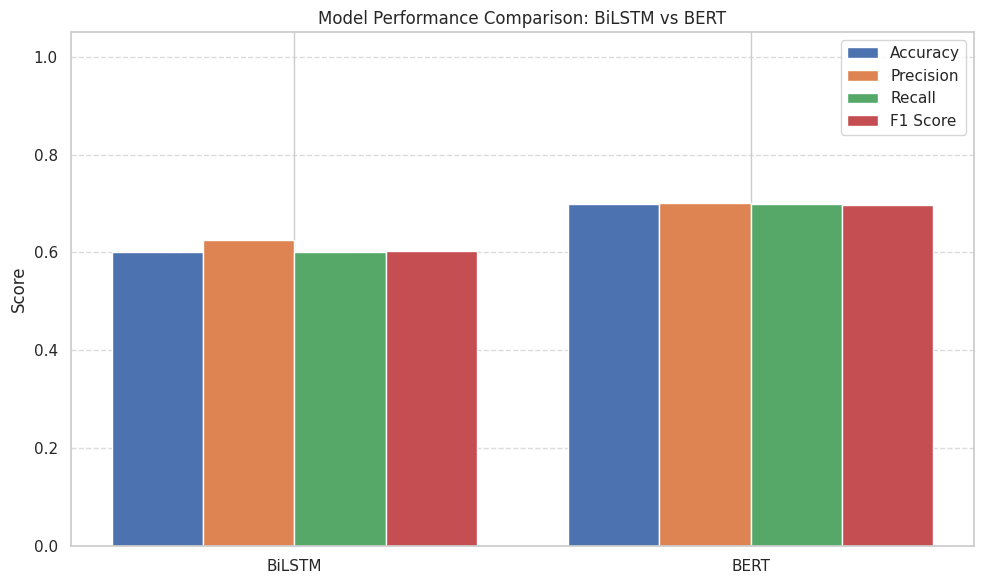

In [108]:

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width - 1.5 * width, results_df[metric], width, label=metric)

plt.xticks(x, results_df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison: BiLSTM vs BERT")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [109]:
# class labels must be integers starting at 0
num_classes = len(label_map)
class_names = list(label_map.keys())

In [110]:
# Binarize true labels for AUC (Test set)
y_true_bilstm = label_binarize(y_true_classes, classes=range(num_classes))
y_true_bilstm_noisy = label_binarize(noisy_true_labels, classes=range(num_classes))
y_true_bert = label_binarize(bert_true_labels, classes=range(num_classes))
y_true_noisy = label_binarize(noisy_true_labels, classes=range(num_classes))

In [111]:
y_pred_bilstm = y_pred_probs  # from bilstm_model.predict(X_test_lstm)
y_pred_bilstm_noisy = noisy_preds.predictions  # from trainer.predict(noisy_test_dataset)
y_pred_bert = predictions.predictions  # from trainer.predict(test_dataset)
y_pred_noisy = noisy_preds.predictions  # from trainer.predict(noisy_test_dataset)

In [112]:
# AUC per model
auc_bilstm = roc_auc_score(y_true_bilstm, y_pred_bilstm, average='weighted', multi_class='ovr')
auc_bilstm_noisy = roc_auc_score(y_true_bilstm_noisy, y_pred_bilstm_noisy, average='weighted', multi_class='ovr')
auc_bert = roc_auc_score(y_true_bert, y_pred_bert, average='weighted', multi_class='ovr')
auc_noisy = roc_auc_score(y_true_noisy, y_pred_noisy, average='weighted', multi_class='ovr')

In [117]:
# Metrics (make sure the metric variables are defined beforehand)
results_comparison = {
    "Model": ["BiLSTM", "BiLSTM (Noisy)", "BERT", "BERT (Noisy)"],
    "Accuracy": [bilstm_accuracy, bilstm_noisy_accuracy, bert_accuracy, accuracy_score(noisy_true_labels, noisy_pred_labels)],
    "F1 Score": [bilstm_f1, bilstm_noisy_f1, bert_f1, precision_recall_fscore_support(noisy_true_labels, noisy_pred_labels, average='weighted')[2]],
    "Precision": [bilstm_precision, bilstm_noisy_precision, bert_precision, precision_recall_fscore_support(noisy_true_labels, noisy_pred_labels, average='weighted')[0]],
    "Recall": [bilstm_recall, bilstm_noisy_recall, bert_recall, precision_recall_fscore_support(noisy_true_labels, noisy_pred_labels, average='weighted')[1]],
    "AUC": [auc_bilstm, auc_bilstm_noisy, auc_bert, auc_noisy]
}


In [118]:
# Create and display comparison DataFrame
results_df = pd.DataFrame(results_comparison)
display(results_df)

,Model,Accuracy,F1 Score,Precision,Recall,AUC
0,BiLSTM,0.600109,0.602115,0.625013,0.600109,0.775224
1,BiLSTM (Noisy),0.321215,0.329885,0.377193,0.321215,0.768961
2,BERT,0.698047,0.696229,0.700973,0.698047,0.834754
3,BERT (Noisy),0.632664,0.622887,0.640962,0.632664,0.768961


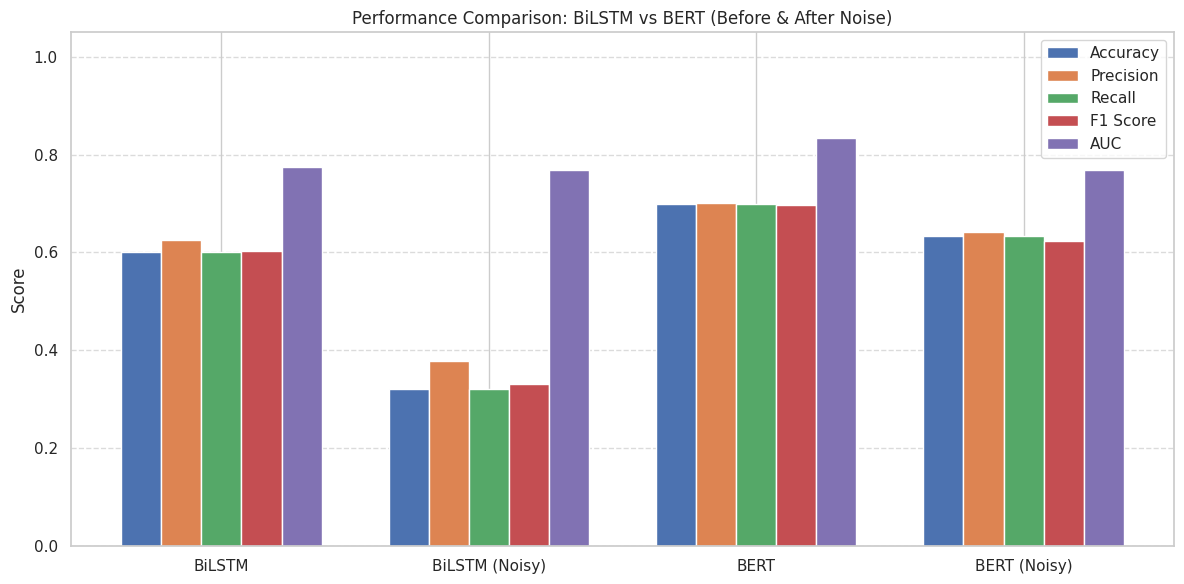

In [119]:
# Plot grouped bar chart
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
x = np.arange(len(results_df["Model"]))
width = 0.15

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width - 0.3, results_df[metric], width, label=metric)

plt.xticks(x, results_df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Performance Comparison: BiLSTM vs BERT (Before & After Noise)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [126]:
# Predicted probabilities (already softmax/logits)
y_pred_bilstm = y_pred_probs
y_pred_bilstm_noisy = noisy_preds.predictions
y_pred_bert = predictions.predictions
y_pred_noisy = noisy_preds.predictions

# Compute AUC scores
auc_bilstm = roc_auc_score(y_true_bilstm, y_pred_bilstm, average='weighted', multi_class='ovr')
auc_bilstm_noisy = roc_auc_score(y_true_bilstm_noisy, y_pred_bilstm_noisy, average='weighted', multi_class='ovr')
auc_bert = roc_auc_score(y_true_bert, y_pred_bert, average='weighted', multi_class='ovr')
auc_noisy = roc_auc_score(y_true_noisy, y_pred_noisy, average='weighted', multi_class='ovr')

# Display AUCs
print(f"🔵 BiLSTM AUC:        {auc_bilstm:.4f}")
print(f"🟡 BiLSTM (Noisy) AUC: {auc_bilstm_noisy:.4f}")
print(f"🟢 BERT AUC:          {auc_bert:.4f}")
print(f"🟠 BERT (Noisy) AUC:  {auc_noisy:.4f}")

🔵 BiLSTM AUC:        0.7752
🟡 BiLSTM (Noisy) AUC: 0.7690
🟢 BERT AUC:          0.8348
🟠 BERT (Noisy) AUC:  0.7690


# The Result...